In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('../')

In [29]:
from SHDataset import SHDataset
from utils.utils import *
from models.rulebased import RulebasedDetector
from models.histogram import HistogramDetector

In [3]:
dataset = SHDataset()
G1,T1,G2,T2 = dataset.read_snapshots(0)

Adding noise to trajectories: 100%|██████████| 89079/89079 [00:56<00:00, 1578.75it/s]


In [4]:
dataset = SHDataset(resample_timedp=True, resample_everyn=16)
_,T1_,_,T2_ = dataset.read_snapshots(0)

Adding noise to trajectories: 100%|██████████| 45558/45558 [00:04<00:00, 10187.88it/s]


In [5]:
def highlight_map(path):
    G_diff = compare_snapshots(G1,G2)[1]
    removed_edges = [(edge[0], edge[1]) for edge in G_diff.edges(data=True) if edge[2]['color'] == 'magenta']

    
    mismatched_edges = []
    remaining_path = []
    for edge in path:
        if edge in removed_edges:
            mismatched_edges.append(edge)
        else:
            remaining_path.append(edge)

    # Color the path green, with mismatched removed edges colored as orange
    path_remaining_colors = {edge: 'green' for edge in remaining_path}
    path_removed_colors =  {edge: 'orange' for edge in mismatched_edges}
    nx.set_edge_attributes(G_diff, path_remaining_colors, name='color')
    nx.set_edge_attributes(G_diff, path_removed_colors, name='color')
    
    return G_diff

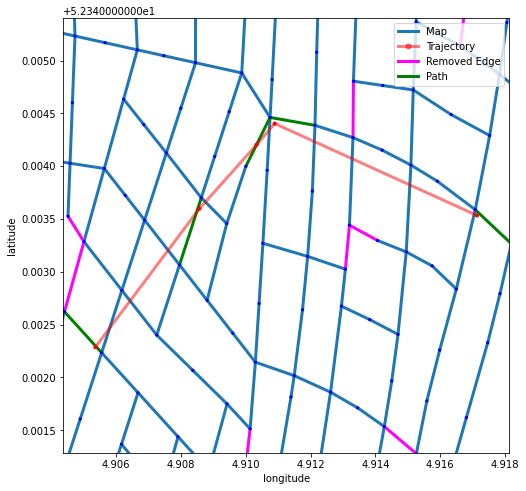

In [34]:
t_idx = 11
t_ = T2_['T'][t_idx]
rule_det = RulebasedDetector(G1)
path = rule_det.map_match_trajectory(t_)
G_path = highlight_map(path)
plot_graph(snapshot_to_nxgraph(G_path, [t_]), zoom_on_traj=True, show_nodes=True, removed_road_edge_width=3, T_edge_width=3,
          T_node_size=10, traj_alpha=.5, G_edge_width=3, savename=os.path.join('./figures', 'rulebased_match_lowtempsparsity'), show_img=False)

Running Histogram Change Detector: 100%|██████████| 1/1 [00:00<00:00, 2935.13it/s]


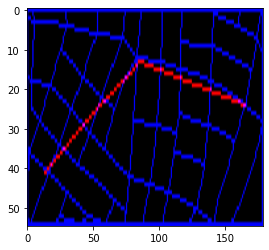

In [62]:
import bresenham

def get_bbox(t, offset=1e-3):
    bbox = (np.min(t['lat'])-offset, np.max(t['lat'])+offset, np.min(t['lon'])-offset, np.max(t['lon'])+offset)
    return bbox
    
def draw_hist_single_t(G, t, aspect=3, savename=None):
    """
    Draws a single trajectory and map on a 2D histogram as the histogram method would do, for visualization purposes
    """
    # Get bounding box from trajectory
    bbox = get_bbox(t)
    
    # Initialize histogram detector, draw the trajectory on a histogram
    hist_det = HistogramDetector(G, bbox)
    hist_det.forward([t])
    
    # Take the absolute value of the histogram, as cell values are set to -1
    t_hist = np.abs(hist_det.hist)
    
    # Do the same for the map
    map_hist = np.abs(hist_det.draw_map_hist(bbox))
    
    # Create an empty green channel, as we willl treat the map as blue pixels, trajectory as red pixels
    g_channel = np.zeros_like(t_hist)
    
    # Stack them together into an image
    img = np.stack([t_hist, g_channel, map_hist], axis=2)
    
    # Show the image
    plt.imshow(np.rot90(img), aspect=aspect)
    
    # Save figure if savename is specified
    if savename is not None:
        fig1 = plt.gcf()
        fig1.savefig(f'{savename}.png', bbox_inches = "tight")
    

draw_hist_single_t(G1, t_, savename=os.path.join('./figures', 'histogram_lowtempspars_traj'))

In [41]:
map_hist = hist_det.draw_map_hist()

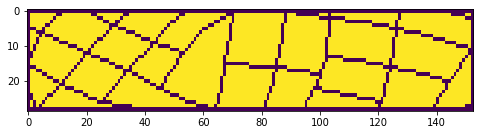

In [42]:
plot_hist(map_hist)

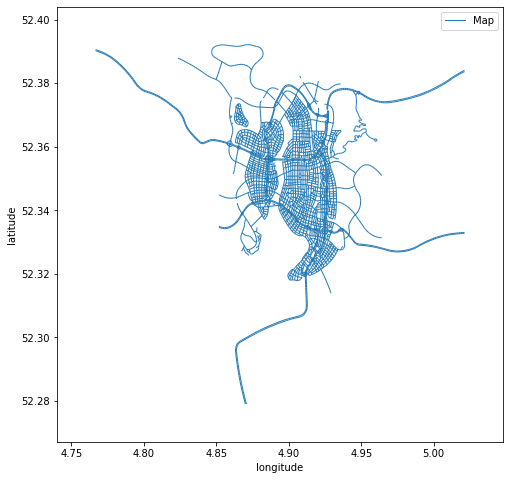